# Kinetic Energy

Mean and Eddy Kinetic Energy

## Theory

For a hydrostatic ocean like MOM5, the relevant kinetic energy per mass is 

$$ KE = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ TKE = \left< K \right > = \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right) dt $$

It is useful to decompose the velocity in the mean and time varying components

$$ u = \bar{u} + u'$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ MKE = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ EKE = \left< \frac{1}{2} \left( \left(u - \left<u\right>\right)^2 + 
                                 \left(v - \left<v\right>\right)^2
                                 \right) \right> $$
                                 
MKE and EKE partition the total kinetic energy

$$TKE = EKE + MKE $$


## Calculation


We start by importing some useful packages.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from tqdm import tqdm_notebook

Start up a dask cluster.

In [2]:
client = cc.start_cluster()
client

Run this command on a local terminal to set up SSH tunnels for dashboard:

  ssh -N -L 36626:127.0.0.1:36626 vdi-n11.nci.org.au -l jm0634


Client Scheduler: tcp://127.0.0.1:40608 Dashboard: http://127.0.0.1:36626,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


While not difficult to write down, this is fairly involved computation since to compute the eddy kinetic energy requires both the velocity and the mean of the velocity components.  Since the dataset is large, we want to avoid loading all of the velocity data into memory at the same time.

To calculate EKE, we need horizontal velocities $u$ and $v$. Here some the experiments that have that kind of data.

In [64]:
import pandas as pd
import sqlite3
conn = sqlite3.connect(cc.netcdf_index.database_file)

df = pd.read_sql('SELECT configuration, experiment, basename_pattern, chunking, count(ncfile) as num_files '
                 'FROM ncfiles '
                 'WHERE variable = "u" '
                 'AND basename_pattern LIKE "%!_!_%.nc" ESCAPE "!" '
                 'GROUP BY configuration, experiment, basename_pattern '
                 'ORDER BY configuration, experiment, num_files '
                 , conn)

In [65]:
df

,configuration,experiment,basename_pattern,chunking,num_files
0,APE-MOM,gfdl_nyf_1080_PI,ocean__\d+_\d+.nc,"[1, 10, 216, 288]",3649
1,APE-MOM,gfdl_nyf_1080_SH,ocean__\d+_\d+.nc,"[1, 10, 216, 288]",3650
2,APE-MOM,gfdl_nyf_1080_UP,ocean__\d+_\d+.nc,"[1, 10, 216, 288]",3650
3,APE-MOM,gfdl_nyf_1080_cp,ocean__\d+_\d+.nc,"[1, 10, 216, 288]",4745
4,mom01v5,GFDL50,rregionocean_kerg__\d+_\d+.nc,"[1, 9, 171, 664]",365
5,mom01v5,GFDL50,rregionoceankerg__\d+_\d+.nc,"[1, 8, 155, 600]",1460
6,mom01v5,KDS75,rregionocean_kerg__\d+_\d+.nc,"[1, 12, 150, 580]",273
7,mom01v5,KDS75,ocean__\d+_\d+.nc,"[1, 7, 300, 400]",720
8,mom01v5,KDS75,rregionoceankerg__\d+_\d+.nc,"[1, 11, 133, 515]",4822
9,mom01v5,KDS75_PI,ocean__\d+_\d+.nc,"[1, 7, 300, 400]",720


### Example

For example, let's calculate the mean and eddy kinetic energy over the last 30 day period of a model run.  We will use the velocity data stored in the NetCDF4 files named

`ocean__\d+_\d+.nc`.

These files store the 5-day averages of the velocity components __u__ and __v__. To compute the 30 day average, we need to consider the last 6 such files. 

(In practice, we would convert this quantity over seasonal or annual timescales.)


Let's pick the `KDS75` experiment

In [4]:
expt = 'KDS75'

Here we build datasets for the variables u and v

In [5]:
u = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=6)
v = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'v', 
                       time_units = 'days since 2000-01-01', 
                       n=6)

Opening 6 ncfiles...
Building dataarray.
Dataarray constructed.
Opening 6 ncfiles...
Building dataarray.
Dataarray constructed.


The kinetic energy is given by

$$ KE = \frac{1}{2} (u^2 + v^2)$$

we construct the following expression:

In [8]:
KE = 0.5*(u**2 + v**2)

You may notice that this line takes a moment to run. The calculation is not (yet) being run. Rather, XArray needs to broadcast the squares of the velocity fields together to determine the final shape of KE. 

(See below for an alternative that skips allows us to skip this intermediate calculation by using dask directly.)

In [9]:
print(KE.shape)

(6, 75, 2700, 3600)


This is too large to store locally.  We need to reduce the data in some way.  

The total kinetic energy is

In [10]:
TKE = KE.mean('time').sum(['st_ocean'])

While we could try and compute this DataArray now, it appears to be  more memory efficient to handle each of the chunks along latitude and longitude separately.

In [12]:
TKE = cc.compute_by_block(TKE)

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

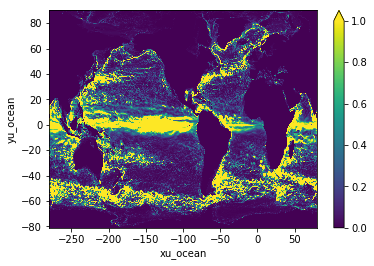

In [13]:
TKE.plot(vmax=1)
plt.show()

## Mean Kinetic Energy

For the mean kinetic energy, we need to average the velocities over time over time.

In [14]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [15]:
MKE = 0.5*(u_mean**2 + v_mean**2)
MKE = MKE.sum('st_ocean')

In [16]:
%%time
MKE = cc.compute_by_block(MKE)

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

CPU times: user 2min 9s, sys: 8.39 s, total: 2min 17s
Wall time: 3min 58s


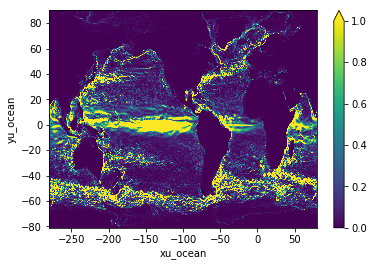

In [17]:
MKE.plot(vmax=1)
plt.show()

## Eddy Kinetic Energy

We calculate the perturbation velocities

In [63]:
u_ = u - u_mean
v_ = v - v_mean

In [68]:
EKE = 0.5 * (u_**2 + v_**2)

In [69]:
EKE = EKE.mean('time').sum(['st_ocean'])

In [ ]:
EKE = cc.compute_by_block(EKE)

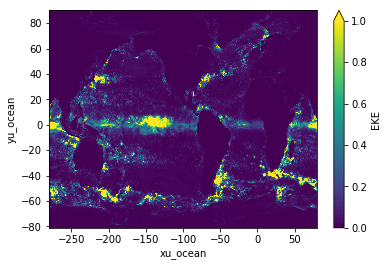

In [73]:
EKE.plot(vmax=1)
plt.show()

We can confirm now that the sum EKE and MKE really is the TKE.

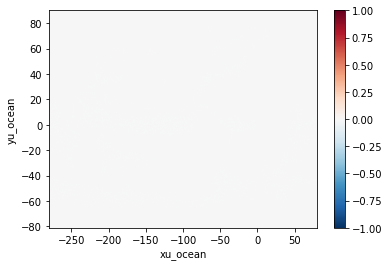

In [81]:
(TKE - (EKE+MKE)).plot(vmax=1)
plt.show()

The above plot is uniformly zero, as expected.

### Functions

In [3]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/',verbose=0)

Here are functions for calculating both MKE and EKE.

In [31]:
@memory.cache
def calc_mke(expt, n=6):
    
    print('Opening datasets...')
    u = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    v = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'v', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    MKE = 0.5*(u_mean**2 + v_mean**2)
    MKE = MKE.sum('st_ocean')
    
    print('Calculating...')
    MKE = cc.compute_by_block(MKE)
    
    return MKE

In [ ]:
%%time
MKE = calc_mke('KDS75', n=6)

In [7]:
@memory.cache
def calc_eke(expt, n=6):
    
    print('Opening datasets...')
    u = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    v = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'v', 
                       time_units = 'days since 2000-01-01', 
                       n=n)
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    u_ = u - u_mean
    v_ = v - v_mean
    
    EKE = 0.5 * (u_**2 + v_**2)
    EKE = EKE.mean('time')
    EKE = EKE.sum(['st_ocean'])
    
    print('Calculating...')
    EKE = cc.compute_by_block(EKE)
    
    return EKE

In [15]:
%%time
EKE = calc_eke('KDS75', n=6)

CPU times: user 974 ms, sys: 1.95 s, total: 2.92 s
Wall time: 2.56 s


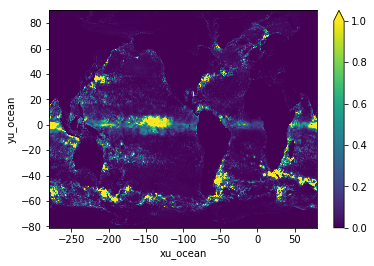

In [15]:
EKE.plot(vmax=1)
plt.show()

In [ ]:
%%time
EKE = calc_eke('KDS75', n=72)

In [ ]:
EKE.plot(vmax=1)
plt.show()

## Using dask directly

Note: Does not (yet) work but performance gains suggest that it may be further debugging for production use.

In [6]:
import netCDF4
import dask.array as da
import dataset

In [10]:
@memory.cache
def calc_mke_dask(expt, n=6):
    
    db = dataset.connect(cc.netcdf_index.database_url)

    res = db.query('SELECT ncfile'
         ' from ncfiles'
         ' where variable = "u"'
         ' AND experiment = "%s"'
         ' AND basename_pattern = "ocean__\d+_\d+.nc"'
         ' ORDER BY ncfile'
         ' LIMIT %d' % (expt, n),
        )
    rows = list(res)

    ncfiles = [row['ncfile'] for row in rows]

    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)

    u_mean = u.mean(axis=0)
    v_mean = v.mean(axis=0)

    MKE = 0.5*(u_mean**2 + v_mean**2)
    MKE = MKE.sum(axis=0)
     
    MKE = cc.compute_by_block(MKE)
    
    temp = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=1)
    template = temp.mean('time').sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = MKE
    result.name = 'MKE'
    
    return result

In [ ]:
%%time
MKE = calc_mke_dask('KDS75', n=6)

In [23]:
@memory.cache
def calc_eke_dask(expt, n=72):

    db = dataset.connect(cc.netcdf_index.database_url)

    res = db.query('SELECT ncfile'
         ' from ncfiles'
         ' where variable = "u"'
         ' AND experiment = "%s"'
         ' AND basename_pattern = "ocean__\d+_\d+.nc"'
         ' ORDER BY ncfile'
         ' LIMIT %d' % (expt, n)
        )
    ncfiles = [row['ncfile'] for row in res]

    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1,7,300,400)) for ncfile in ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)

    u_mean = u.mean(axis=0)
    v_mean = v.mean(axis=0)

    u_ = u - u_mean
    v_ = v - v_mean

    EKE = 0.5 * (u_**2 + v_**2)
    EKE = EKE.mean(axis=0)
    EKE = EKE.sum(axis=0)
    
    EKE = cc.compute_by_block(EKE)
        
    temp = cc.get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', 
                       time_units = 'days since 2000-01-01', 
                       n=1)
    template = temp.mean('time').sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = EKE
    result.name = 'EKE'
    
    return result

In [ ]:
%%time
EKE = calc_eke_dask('KDS75', 2)

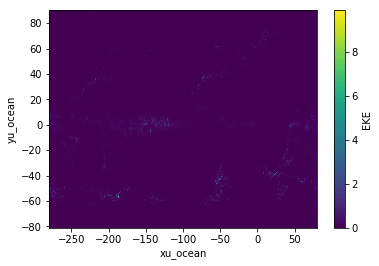

In [26]:
EKE.plot(vmax=1)
plt.show()

## Visualization

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Opening 6 ncfiles...
Building dataarray.
Dataarray constructed.
Opening 6 ncfiles...
Building dataarray.
Dataarray constructed.


HBox(children=(IntProgress(value=0, max=81), HTML(value='')))

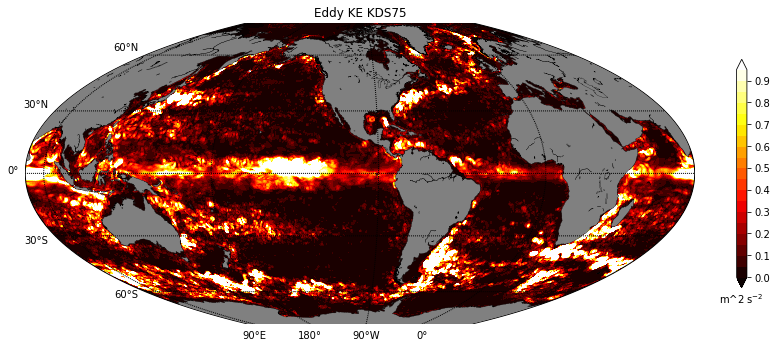

In [34]:
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

expt = 'KDS75'
dsx = calc_eke(expt, n=6)
    
x=dsx.xu_ocean[:]
y=dsx.yu_ocean[:]
lon, lat = np.meshgrid(x, y)
    
X, Y = map(lon,lat) 

map.contourf(X, Y, dsx.data,
                 cmap=plt.cm.hot,
                 levels=lev,
                 extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Eddy KE {}'.format(expt))